In [409]:
from yahoo_fin import stock_info as si
from matplotlib import pyplot as plt 
import pandas_datareader as dr
import quandl
import pandas as pd
import numpy as np
from pandas_datareader import data as wb
import datetime
import yfinance as yf
from requests_html import HTMLSession

'''----// General input variables //----'''


long_term_growth = 0.01 # динамическое значение инфляции для каждой страны
iterations = 1000


In [410]:
data_csv_ticker = pd.read_csv('TICKER_companies.csv')
data_csv = data_csv_ticker.set_index('country')
data_ticker = data_csv[['ticker', 'compnumber']]

CAN = data_ticker.loc['CAN']    # дергаем отсюда тикер и номер компании
DEU = data_ticker.loc['DEU']


# ДАННЫЕ КОМПАНИИ

In [411]:
COUNTRY = DEU
COMPANY = 'SIEG Y'

# ---------------------------

In [412]:
company_number = COUNTRY.set_index('ticker').loc[COMPANY]['compnumber']
company_number

7576

In [413]:
quandl.ApiConfig.api_key = 'c3baa8FMfeFWP_wpbhKL'

data = pd.DataFrame(quandl.get_table('MER/F1', compnumber=company_number, reporttype='A',  paginate=True))

main_data = data.sort_values(by=['reportdate']).set_index('indicator')
data_amount = main_data['amount']

work_table = pd.DataFrame()

work_table['date'] = main_data['reportdate'].T.drop_duplicates().T.reset_index(drop=True)


work_table['revenue'], work_table['operatingIncome'], work_table['netIncome'], work_table['eps'],\
    work_table['ebitda'], work_table['totalAssets'], work_table['operatingMargin'], work_table['currentLiabilities'],\
    work_table['currentAssets'], work_table['interestExpense'], work_table['stockholdersEquity'], work_table['shares'], \
    work_table['taxRate'], work_table['ROE'],\
    = data_amount['Total Revenue'].reset_index(drop=True), data_amount['Operating Income'].reset_index(drop=True),\
      data_amount['Net Income'].reset_index(drop=True), data_amount['EPS - Net Income - Basic'].reset_index(drop=True), \
      data_amount['EBITDA'].reset_index(drop=True), data_amount['Total Assets'].reset_index(drop=True), \
      data_amount['Operating Margin'].reset_index(drop=True), data_amount['Current Liabilities'].reset_index(drop=True), \
      data_amount['Current Assets'].reset_index(drop=True), data_amount['Interest Coverage'].reset_index(drop=True), \
      data_amount['''Stockholders' Equity'''].reset_index(drop=True), data_amount['Shares Outstanding'].reset_index(drop=True),\
      data_amount['Calculated Tax Rate'].reset_index(drop=True), data_amount['Return on Equity'].reset_index(drop=True)
      



work_table['grossProfit'] = (data_amount['Gross Margin'].reset_index(drop=True) * data_amount['Total Revenue'].reset_index(drop=True)) / 100

work_table['totalDebt'] = (data_amount['Total Debt to Equity'].reset_index(drop=True) * data_amount['''Stockholders' Equity'''].reset_index(drop=True))

work_table['longTermObligations'] = (data_amount['Long Term Debt to Equity'].reset_index(drop=True) * data_amount['''Stockholders' Equity'''].reset_index(drop=True))

work_table['netDebt'] = work_table['currentLiabilities'] + work_table['totalDebt'] - work_table['currentAssets']


work_table['incomeTaxExpense'] = work_table['netIncome'] * data_amount['Calculated Tax Rate'].reset_index(drop=True)

work_table['incomeBeforeTax'] = work_table['netIncome'] + work_table['incomeTaxExpense']



In [414]:
work_table = work_table[::-1][:10].reset_index(drop=True).fillna(0)
work_table
year_len = len(work_table.index) - 1 #

In [415]:
# расчет стандартного отоклонения для CAGR

mean_cagr_9_year = [] # cоздаем список для CAGR на 10 лет период 1 год
mean_cagr_net_income_9_year = []# cоздаем список для CAGR_income на 10 лет период 1 год

# считаем   CAGR  на 10 лет период 1 год
for j in range(1, year_len+1):
    mean_cagr_9_year.append((work_table['revenue'][j-1] / work_table['revenue'][j])**(1)-1)
    mean_cagr_net_income_9_year.append((work_table['netIncome'][j-1] / work_table['netIncome'][j])**(1)-1)
    
cagr_dict = {"revenue_cagr":mean_cagr_9_year, "netIncome_cagr": mean_cagr_net_income_9_year}
cagr_df = pd.DataFrame(cagr_dict) # получаем датафрейм для отклонения, используем при распредилеии 

In [416]:
'''----// Calculate average revenue CAGR & EBIT margin //----'''
    
mean_cagr = (work_table['revenue'][0] / work_table['revenue'][year_len])**(1/year_len)-1
cagr_net_income = (work_table['netIncome'][0] / work_table['netIncome'][year_len])**(1/year_len)-1
mean_margin = work_table['operatingMargin'].mean() / 100   


'''----// Create forecast function through which random variables will flow //----'''



def get_forecast(cagr, margin, long_term_growth, cagr_net_income):
    forecast_lst = []

    for i in range(5):
#         if i < 5:
        operating_income = (np.random.normal(work_table['revenue'][0], work_table['revenue'].std())*(1+cagr)**(i+1)*margin) # учитываем распределение 'revenue' шаг - стандартное отклонение
        net_income = operating_income*(np.random.normal(work_table['taxRate'][0], work_table['taxRate'].std())/100) # учитываем распределение 'taxRate' шаг - стандартное отклонение
        reinvest_cof = cagr_net_income / np.random.normal(work_table['ROE'].mean(), work_table['ROE'].std())  # учитываем распределение 'ROE' шаг - стандартное отклонение
        reinvest = net_income * reinvest_cof
        forecast_lst.append(operating_income - net_income - reinvest)
#         else: 
#             forecast_lst.append((work_table['revenue'][0]*(1+cagr)**(i)*margin)-((work_table['revenue'][0]*(1+cagr)**(i)*margin)*(work_table['taxRate'][0]/100))-(((work_table['revenue'][0]*(1+cagr)**(i)*margin)*(work_table['taxRate'][0]/100))*(cagr/work_table['ROE'].mean()))*(1 + long_term_growth)) 

    return forecast_lst



In [417]:
(work_table['revenue'][0]*(1+cagr)**(i+0)*margin)-((work_table['revenue'][0]*(1+cagr)**(0+1)*margin)*(work_table['taxRate'][0]/100))-(((work_table['revenue'][0]*(1+cagr)**(0+1)*margin)*(work_table['taxRate'][0]/100))*(cagr/work_table['ROE'].mean()))

8.343905415356116e+45

In [418]:
# ________________________________________  Расчет WACC  _______________________________________________
start = datetime.datetime(2019, 2, 1)
end= datetime.datetime.today().strftime('%Y-%m-%d')

# Получаем ставку облигации

session = HTMLSession()
oblig_site = session.get('https://tradingeconomics.com/bonds')
oblig_pars = oblig_site.html.find('#p')

# ^GSPTSE - CA
# ^GDAXI - DE

obligation_dict = {"DEU":[oblig_pars[3].text], "CAN": [oblig_pars[31].text]}
obligation = pd.DataFrame(obligation_dict)


RF = float(obligation[COUNTRY.index[0]][0]) / 100
print(f'RF {RF}')

# Парсим beta с yahoo finance
pars_data_beta = yf.Ticker(COMPANY.replace(' ', '')) #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
beta = pars_data_beta.info['beta']  
print(f'beta {beta}')

# Считаем годовую доходность
data = wb.DataReader('^GDAXI', data_source='yahoo', start='2001-1-1') # нужно определиться с переменной индекс
data['simple_return'] = (data['Adj Close'] / data['Adj Close'].shift(1)) - 1
data['simple_return'].replace(np.nan, 0)
avg_returns_a = data['simple_return'].mean() * 250

print(f'Годовая доходность S&P500 {avg_returns_a*100}')

 
ke = RF + (beta * (avg_returns_a - RF))
print(f'Стоимость капитала {ke*100}')

pars_mktCap = yf.Ticker(COMPANY.replace(' ', '')) #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
marketCap = pars_data_beta.info['marketCap']  # перевод валюты



WACC = ((marketCap / 1.22) / ((marketCap / 1.22) + work_table['netDebt'][0:2].mean())) * ke + (
                work_table['netDebt'][0:2].mean() / ((marketCap / 1.22) + work_table['netDebt'][0:2].mean())) * (
                        work_table['interestExpense'][0] / work_table['netDebt'][0:2].mean()) \
               * (1 - (work_table['incomeTaxExpense'][0] / work_table['incomeBeforeTax'][0]))

print(f'WACC {WACC}')


RF -0.0060999999999999995
beta 1.108527
Годовая доходность S&P500 6.574883010223573
Стоимость капитала 7.354636808674107
WACC 0.06250948495826304


In [419]:
(marketCap / 1.22)

91417616786.88525

In [420]:
mean_wacc = WACC
net_debt = work_table['netDebt'][0]

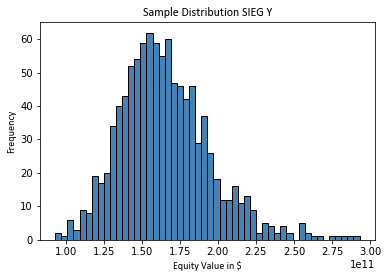

166.43004001452138
239.83653504106522


In [421]:
'''----// Discount EBIT figures to arrive at the PV of the firm's cash flows //----'''

def discount(forecast, discount_rate, long_term_rate):
    discount_lst = []
    for x,i in enumerate(forecast):
        if x < 5:
            discount_lst.append(i/(1+discount_rate)**(x+1))
        else:
            discount_lst.append(i/(discount_rate-long_term_rate)*(1/(1+discount_rate)**5))
    return sum(discount_lst)

'''----// Run simulation and plot distribution of model forecasts //----'''

hist_lst = []

for i in range(iterations):
    cagr = np.random.normal(mean_cagr, cagr_df['revenue_cagr'].std()) # шаг в качестве стандартного отклоенения
    cagr_net_income_normal = np.random.normal(cagr_net_income, cagr_df['netIncome_cagr'].std())# шаг в качестве стандартного отклоенения
    margin = np.random.normal(mean_margin, (work_table['operatingMargin'] / 100).std() )# шаг в качестве стандартного отклоенения
    long_term_rate = np.random.normal(long_term_growth, 0.001)
    discount_rate = np.random.normal(mean_wacc, 0.001)
    assets = np.random.normal(work_table['currentAssets'][0], work_table['currentAssets'].std()) # шаг в качестве стандартного отклоенения
    forecast1 = get_forecast(cagr, margin, long_term_rate, cagr_net_income_normal)
    forecast = forecast1.append(forecast1[4]*(1+long_term_growth)) 
    hist_lst.append(discount(forecast1, discount_rate, long_term_rate)-net_debt + assets)
hist_array = np.array(hist_lst)
plt.hist(hist_array, bins=50, align='mid', color = 'steelblue', edgecolor='black')
plt.title('Sample Distribution ' + COMPANY, {'fontname':'Calibri'})
plt.xlabel('Equity Value in $', {'fontname':'Calibri'})
plt.ylabel('Frequency', {'fontname':'Calibri'})

plt.show()

mean = hist_array.mean()
standard_error = hist_array.std()

lower_bound = (mean-standard_error) / work_table['shares'][0] # work_table['stockholdersEquity']
upper_bound = (mean+standard_error ) / work_table['shares'][0] # work_table['stockholdersEquity']



print(lower_bound)
print(upper_bound)

In [422]:
get_forecast(cagr, margin, long_term_growth, cagr_net_income_normal) # Forcast на 5 лет

[4465779291.183909,
 4339637177.332547,
 3869873338.730422,
 3362897094.598964,
 3554681803.4633746]